## Detection of Anomalies in Financial Transactions using Isolation Forests


## Introduction and Experiment Overview

### Fraud and Accounting Information Systems (AIS)

Financial Institutions contain and process sensitive personal information of its customers and they are mandated to ensure the security of the institution, its partners, and the security of the financial sector as a whole. 
However, **fraud**, embezzlement, money laundering, and suspicious terrorist financing pose a major threat to the security of the financial sector. 
**Fraud** is any deceptive action that is purposefully designed to provide the person with an unlawful gain or to deny a right to a victim. Types of fraud include credit card fraud, accounting fraud, wire fraud, securities fraud, and tax fraud. 

A recent study conducted by the auditors of **PwC** in 2020, revealed that 58% of Kenyan respondents experienced economic crimes in the past two years which is higher than the Global average of 47% and that 44% of Kenyan companies that experienced economic crimes had between 6-10 incidents reported in the last 24 months. Out of the economic crimes experienced, Accounting/Financial Statement fraud ranked third in Kenya at 15% with the top internal perpetrators being Operations staff at 53%, Middle management at 28% and Senior management at 18% (PwC, 2020).

<img align="middle" style="max-width: 550px; height: auto" src="images/accounting.png">

**Figure 1:** Hierarchical view of an Accounting Information System (AIS) that records distinct layers of abstraction, namely (1) the business process information, (2) the accounting information as well as the (3) technical journal entry information in designated database tables.

The Accounting Information System shown above indicates 3 distinct levels which are:

1. Business processes
2. Accounting information
3. Journal entries stored in the database.

Such accounting systems collect vast quantities of financial data that also doubles up as electronic evidence. This snapshot containing journal entries information in their designated database tables is just a drop in the ocean of the huge number of entries/transactions recorded per day for a Financial Institution. Relating this to fraud, the financial data steadily collected by such systems may contain valuable traces of suspicious financial transactions. These suspicious transactions are manifested in the form of anomalies in the journal entries.

### Classification of Financial Anomalies

There exists two classes of anomalous journal entries, namely **"global"** and **"local"** anomalies.

> - Global Anomalies, are financial transactions that display highly unusual individual attribute values. These anomalies usually relate to highly skewed attributes e.g. unusual times of posting, or ledgers that are rarely used. It has been standard practice over the years that "red-flag" tests, performed by auditors during annual audits, are specifically designed to capture those types of anomalies. However, such tests might result in a high volume of false positive alerts due to regular reverse postings which are not fraudulent and year-end adjustments usually associated with a low fraud risk.

> - Local Anomalies, are financial transactions that exhibit an unusual or rare combination of attribute values while the individual attribute values occur quite frequently e.g. unusual accounting records.
This type of anomaly is significantly more difficult to detect since perpetrators intend to disguise their activities trying to imitate a regular behavior. As a result, such anomalies usually pose a high fraud risk since they might correspond to e.g. misused user accounts, irregular combinations of general ledger accounts and posting keys that don't follow an usual activity pattern.


<img align="middle" style="max-width: 450px; height: auto" src="images/anomalies.png">

**Figure 2:** Illustrative example of global and local anomalies portrait in a feature space of the two transaction features "Posting Amount" (Feature 1) and "Posting Positions" (Feature 2).

In [1]:
# Libraries import
# importing utilities
import os
import sys
from datetime import datetime
import io
import urllib

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing sklearn libraries
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# import visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import Image, display
sns.set_style('darkgrid')

# ignore potential warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#Random seed initialization
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed

## Financial Fraud Detection Dataset

Below is a descriptive analysis of the labs financial dataset. Furthermore, I shall apply some necessary pre-processing steps to train an Isolation Forest model. The dataset is based on a derivation of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas available via the Kaggle predictive modelling and analytics competitions platform that can be obtained using the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

First, let us load the dataset and investigate its structure and attributes:

In [4]:
# load the dataset into the notebook kernel
ori_dataset = pd.read_csv('data/fraud_dataset_v2.csv')

In [5]:
# inspect the datasets dimensionalities
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20220726-17:16:10] Transactional dataset of 533009 rows and 10 columns loaded


### Initial Data and Attribute Assessment

Below is the augmented dataset that has been modified to mimick a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

Let's also have a closer look into the top 10 rows of the dataset:

In [6]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


The attribute `label` in the data is of key importance. I shall use this field throughout the experiment to evaluate the quality of my trained models. The field describes the true nature of each individual transaction of either being a **regular** transaction (denoted by `regular`) or an **anomaly** (denoted by `global` and `local`). 

Let's have closer look into the distribution of the regular vs. anomalous transactions in the dataset:

### Anomaly Distribution 

In [7]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

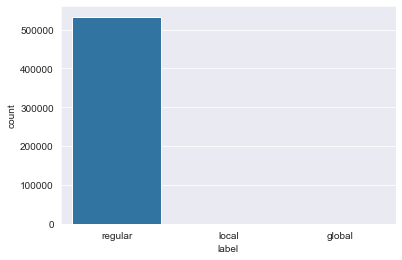

In [8]:
sns.countplot(x=ori_dataset["label"], data=ori_dataset)

This statistic reveals that, similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of **100 (0.018%)** anomalous transactions. While the 100 anomalous entries encompass **70 (0.013%)** "global" anomalies and **30 (0.005%)** "local" anomalies.

In [9]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

### Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above we can observe that the majority of attributes recorded in AIS- and ERP-systems correspond to categorical (discrete) attribute values, e.g. the posting date, the general-ledger account, the posting type, the currency. Let's have a more detailed look into the distribution of two dataset attributes, namely (1) the posting key `BSCHL` as well as (2) the general ledger account `HKONT`:

Text(0.5, 1.0, 'Distribution of HKONT attribute values')

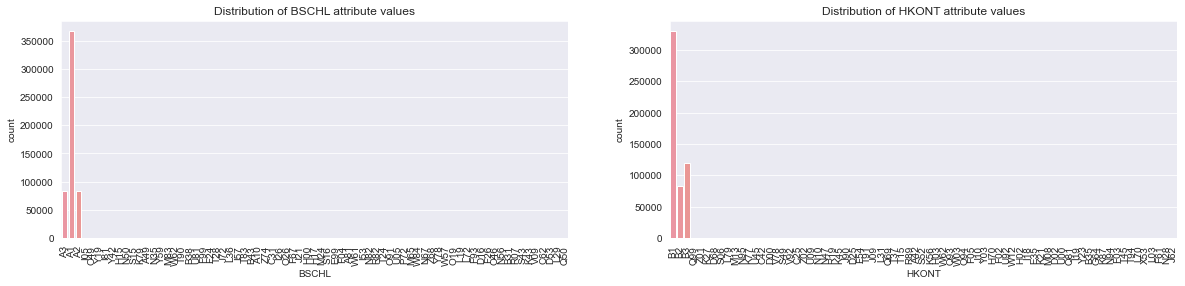

In [10]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of HKONT attribute values')

The Isolation Forest Algorithm is not designed to be trained directly on categorical data and require the attributes to be trained on to be numeric. One simple way to meet this requirement is by applying a technique referred to as **"one-hot" encoding**. Using this encoding technique, I shall derive a numerical representation of each of the categorical attribute values. One-hot encoding creates new binary columns for each categorical attribute value present in the original data. This can be achieved using the `get_dummies()` function available in the Pandas data science library:  

In [11]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'WAERS', 'BUKRS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

## Encoded Transactions

In [12]:
# inspect encoded sample transactions
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W67,BUKRS_W69,BUKRS_W71,BUKRS_W77,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount `DMBTR` and the (2) document currency amount `WRBTR`:

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

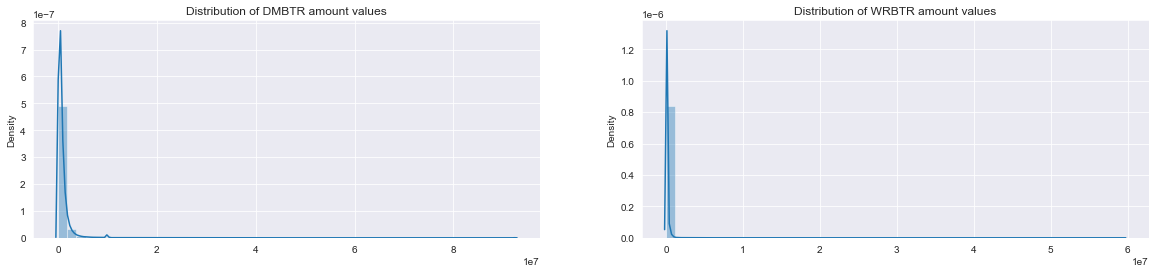

In [13]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

As expected, it can be observed, that for both attributes the distributions of amount values are heavy tailed. In order to approach faster a potential global minimum scaling and normalization of numerical input values is good a practice. Therefore, I first log-scaled both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [14]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

## Visualization of the log-scaled and mini-max normalized distributions of both attributes

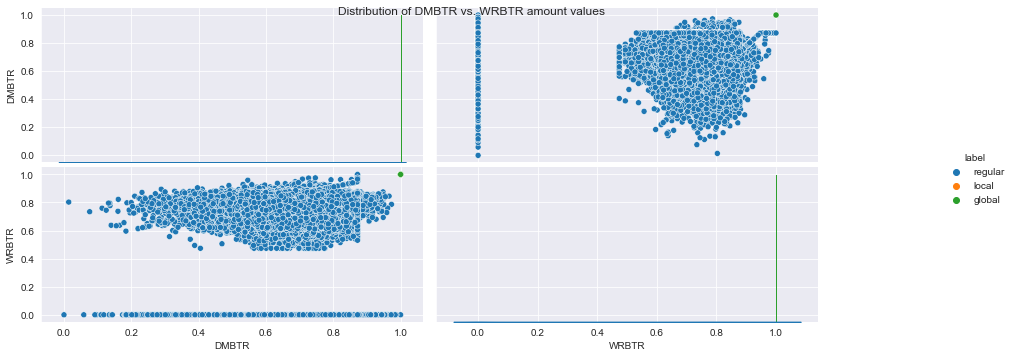

In [15]:
# append 'label' attribute for colour distinction
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label')
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)

As anticipated the numeric attribute values of the "global" anomalies (green) fall outside the range of the regular amount distributions due to their unusual high amount values. In contrast, the numeric attribute values of the "local" anomalies (orange) are much more intertwined within the regular transaction amounts.

### Merge Categorical and Numerical Transaction Attributes

Finally, I merged both pre-processed numerical and categorical attributes into a single dataset that we will use for training my Isolation Forest model.

In [16]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

Let us have a look at the dimensionality of the dataset after we applied the distinct pre-processing steps to the attributes:

In [17]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

Ok, upon completion of all the pre-processing steps (incl. the exercises) I ended up with an encoded dataset consisting of a total number of 533,009 records (rows) and **618 encoded attributes** (columns).

In [18]:
# Splitting the dataset
X = ori_subset_transformed
labels = label.replace(['regular','local','global'],[0,1,1])
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply PCA First

In [19]:
from sklearn.decomposition import PCA
components = 0.96
pca_96 = PCA(n_components=components, random_state=2022)
pca_96.fit(X_train)
X_pca_96 = pca_96.transform(X_train)
print(X_pca_96.shape)

(373106, 144)


In [20]:
X_dt = pd.DataFrame(X_pca_96, index=X_train.index)
print(X_dt.shape)

(373106, 144)


### Isolation Forest Algorithm 

In [21]:
#%%timeit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
estimators = 150
maximum_features = 1.0
contaminant = 0.00018
isf=IsolationForest(n_estimators=estimators, max_samples=len(X_train), contamination=0.00018, \
                        max_features=maximum_features, bootstrap=False, n_jobs=-1, random_state=40, verbose=0)
isf.fit(X_train)

IsolationForest(contamination=0.00018, max_samples=373106, n_estimators=150,
                n_jobs=-1, random_state=40)

In [22]:
#scores_prediction = model.decision_function(X_train)
# Predictions
predictions = isf.predict(X_train)

In [23]:
print(len(predictions))

373106


# Extract predictions and isolation scores

In [24]:
# Extract scores
X_dt_normal = X_train
print(X_dt_normal.shape)
X_dt_normal["iso_forest_scores"] = isf.decision_function(X_dt_normal)# Extract predictions
X_dt_normal["iso_forest_outliers"] = predictions# Describe the dataframe
X_dt_normal.describe()

(373106, 618)


,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98,DMBTR,WRBTR,iso_forest_scores,iso_forest_outliers
count,373106.0,373106.0,373106.0,373106.000000,373106.000000,373106.000000,373106.000000,373106.000000,373106.000000,373106.000000,...,373106.000000,373106.000000,373106.0,373106.000000,373106.000000,373106.000000,373106.000000,373106.000000,373106.000000,373106.000000
mean,0.0,0.0,0.0,0.000003,0.515950,0.121389,0.050758,0.000003,0.051698,0.051208,...,0.000003,0.000003,0.0,0.000003,0.000003,0.000003,0.691150,0.362006,0.018868,0.999635
std,0.0,0.0,0.0,0.001637,0.499746,0.326579,0.219503,0.001637,0.221418,0.220422,...,0.001637,0.001637,0.0,0.001637,0.001637,0.001637,0.074986,0.386916,0.004774,0.026998
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.068989,-1.000000
25%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.651589,0.000000,0.015887,1.000000
50%,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.698308,0.000000,0.019254,1.000000
75%,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.738261,0.772949,0.022830,1.000000
max,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.027710,1.000000


In [25]:
# Replace "-1" with "Yes" and "1" with "No"
X_dt_normal['iso_forest_outliers'] = X_dt_normal['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])# Print the first 5 transactions
X_dt_normal.head()

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98,DMBTR,WRBTR,iso_forest_scores,iso_forest_outliers
318867,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0.734544,0.000000,0.017053,No
520356,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0.739291,0.796416,0.016916,No
84259,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.667707,0.689865,0.025757,No
370486,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.648617,0.000000,0.014606,No
373233,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.621480,0.000000,0.024601,No


In [26]:
X_dt_normal.iso_forest_outliers.value_counts()

No     373038
Yes        68
Name: iso_forest_outliers, dtype: int64

# Training Evaluation 

In [32]:
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
anomaly_scores = pd.DataFrame(predictions, index=X_train.index, columns=['anomaly_score'])
anomaly_scores_idx = anomaly_scores[(anomaly_scores== -1)].dropna().index
pred = pd.DataFrame(index=X_train.index)
pred['fraud'] = 0
for x in anomaly_scores_idx:
    pred['fraud'].loc[x] = 1
    
print(pred.fraud.value_counts())
print(classification_report(y_train, pred['fraud']))
print('Rate of transations to investigate:', len(anomaly_scores_idx) / len(X_train) * 100, '%')
#print(anomaly_scores_idx)

0    373038
1        68
Name: fraud, dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    373029
           1       0.81      0.71      0.76        77

    accuracy                           1.00    373106
   macro avg       0.90      0.86      0.88    373106
weighted avg       1.00      1.00      1.00    373106

Rate of transations to investigate: 0.01822538367112831 %


## Report Visualization

<AxesSubplot:>

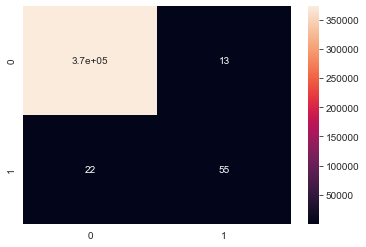

In [33]:
sns.heatmap(confusion_matrix(y_train, pred['fraud']), annot = True)

> - Accuracy : 99%
> - Precision: 81%
> - Recall : 71%
> - F1 Score: 76%

# Testing Evaluation

In [35]:
#test predictions
test_predictions = isf.predict(X_test)

test_scores = pd.DataFrame(test_predictions, index=X_test.index, columns=['test_score'])
test_scores_idx = test_scores[(test_scores== -1)].dropna().index
print((test_scores_idx))
pred = pd.DataFrame(index=X_test.index)
pred['fraud'] = 0
for x in test_scores_idx:
    pred['fraud'].loc[x] = 1
    
print(pred.fraud.value_counts())
print(classification_report(y_test, pred['fraud']))
print('Rate of transations to investigate:', len(test_scores_idx) / len(X_test) * 100, '%')

Int64Index([445659, 363813, 355842,  48585, 112020, 377480,   3228, 357945,
             58274, 182847, 456721],
           dtype='int64')
0    159892
1        11
Name: fraud, dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159880
           1       0.00      0.00      0.00        23

    accuracy                           1.00    159903
   macro avg       0.50      0.50      0.50    159903
weighted avg       1.00      1.00      1.00    159903

Rate of transations to investigate: 0.006879170497113876 %


## Report Visualization 

<AxesSubplot:>

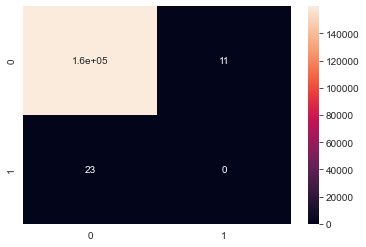

In [36]:
sns.heatmap(confusion_matrix(y_test, pred['fraud']), annot = True)

> - Accuracy : 99%
> - Precision: 0%
> - Recall : 0%
> - F1 Score: 0%